This notebook provides code to clean and refine data files by:
- Removing null/empty values
- Validating data formats
- Removing duplicates
- Standardizing data entries
- Providing visual analysis of data quality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import glob
import os
import shutil
import re
from datetime import datetime, timedelta
import json
import warnings
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

In [2]:
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

DATA_PATH = "./data"
OUTPUT_PATH = "./data_cleaned"
BACKUP_PATH = "./data_backup"

print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Backup path: {BACKUP_PATH}")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

for path in [OUTPUT_PATH, BACKUP_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")

Data path: ./data
Output path: ./data_cleaned
Backup path: ./data_backup
Analysis date: 2025-09-05 10:27:33


In [4]:
csv_files = glob.glob(f"{DATA_PATH}/*.csv")
excel_files = glob.glob(f"{DATA_PATH}/*.xlsx")
all_files = csv_files + excel_files

print(f"CSV files found: {len(csv_files)}")
print(f"Excel files found: {len(excel_files)}")
print(f"Total files: {len(all_files)}")

CSV files found: 6
Excel files found: 4
Total files: 10


In [5]:
file_analysis = {}

print("\nFile Analysis:")
for file_path in all_files:
    filename = os.path.basename(file_path)
    file_size = os.path.getsize(file_path) / 1024 / 1024
    file_type = 'unknown'
    if 'customer' in filename.lower():
        file_type = 'customer'
    elif 'revenue' in filename.lower() or 'sales' in filename.lower():
        file_type = 'sales'
    elif 'inventory' in filename.lower():
        file_type = 'inventory'
    elif 'business' in filename.lower():
        file_type = 'business'
    
    file_analysis[filename] = {
        'path': file_path,
        'size_mb': file_size,
        'type': file_type,
        'extension': os.path.splitext(filename)[1]
    }
    
    print(f"{filename} ({file_size:.2f} MB) - {file_type}")

file_summary_df = pd.DataFrame.from_dict(file_analysis, orient='index')
print(f"\n {len(all_files)} files")


File Analysis:
Customers-20250808_0924_EDT.csv (3.62 MB) - customer
POKE HANA-Revenue Item Sales 08_08_2025.csv (0.04 MB) - sales
Customers-20250808_0923_EDT.csv (3.90 MB) - customer
MARATHON LIQUORS-Revenue Item Sales 08_08_2025.csv (0.18 MB) - sales
Anthony's Pizza & Pasta-Revenue Item Sales 08_08_2025.csv (0.17 MB) - sales
Customers-20250808_0920_EDT.csv (1.47 MB) - customer
inventory-export-v2.xlsx (1.17 MB) - inventory
inventory-export-2.xlsx (0.03 MB) - inventory
inventory-export.xlsx (0.03 MB) - inventory
customer_list-4.xlsx (0.08 MB) - customer

 10 files


In [6]:
def analyze_data(file_path, sample_rows=1000):
    filename = os.path.basename(file_path)
    
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path, encoding='utf-8-sig', nrows=sample_rows)
        else:
            df = pd.read_excel(file_path, nrows=sample_rows)
        
        total_rows = len(df)
        total_cols = len(df.columns)
        total_cells = total_rows * total_cols
        
        null_counts = df.isnull().sum()
        total_nulls = null_counts.sum()
        null_percentage = (total_nulls / total_cells) * 100
        
        empty_strings = 0
        for col in df.select_dtypes(include=['object']).columns:
            empty_strings += (df[col] == '').sum()
        
        duplicate_rows = df.duplicated().sum()
        
        return {
            'filename': filename,
            'total_rows': total_rows,
            'total_columns': total_cols,
            'total_cells': total_cells,
            'total_nulls': int(total_nulls),
            'null_percentage': null_percentage,
            'empty_strings': int(empty_strings),
            'duplicate_rows': int(duplicate_rows),
            'columns': list(df.columns),
            'null_by_column': null_counts.to_dict(),
            'data_types': df.dtypes.astype(str).to_dict(),
            'sample_data': df.head(3).to_dict('records')
        }
        
    except Exception as e:
        return {
            'filename': filename,
            'error': str(e),
            'total_rows': 0,
            'total_columns': 0,
            'null_percentage': 0
        }

In [7]:
quality_analysis = {}

for file_path in all_files:
    filename = os.path.basename(file_path)
    print(f"Analyzing: {filename}")
    quality_analysis[filename] = analyze_data(file_path)

print("\nQuality analysis completed!")

Analyzing: Customers-20250808_0924_EDT.csv
Analyzing: POKE HANA-Revenue Item Sales 08_08_2025.csv
Analyzing: Customers-20250808_0923_EDT.csv
Analyzing: MARATHON LIQUORS-Revenue Item Sales 08_08_2025.csv
Analyzing: Anthony's Pizza & Pasta-Revenue Item Sales 08_08_2025.csv
Analyzing: Customers-20250808_0920_EDT.csv
Analyzing: inventory-export-v2.xlsx
Analyzing: inventory-export-2.xlsx
Analyzing: inventory-export.xlsx
Analyzing: customer_list-4.xlsx

Quality analysis completed!


In [8]:
quality_df = pd.DataFrame.from_dict(
    {k: {key: v[key] for key in ['filename', 'total_rows', 'total_columns', 'null_percentage', 'duplicate_rows']} 
     for k, v in quality_analysis.items() if 'error' not in v}, 
    orient='index'
)

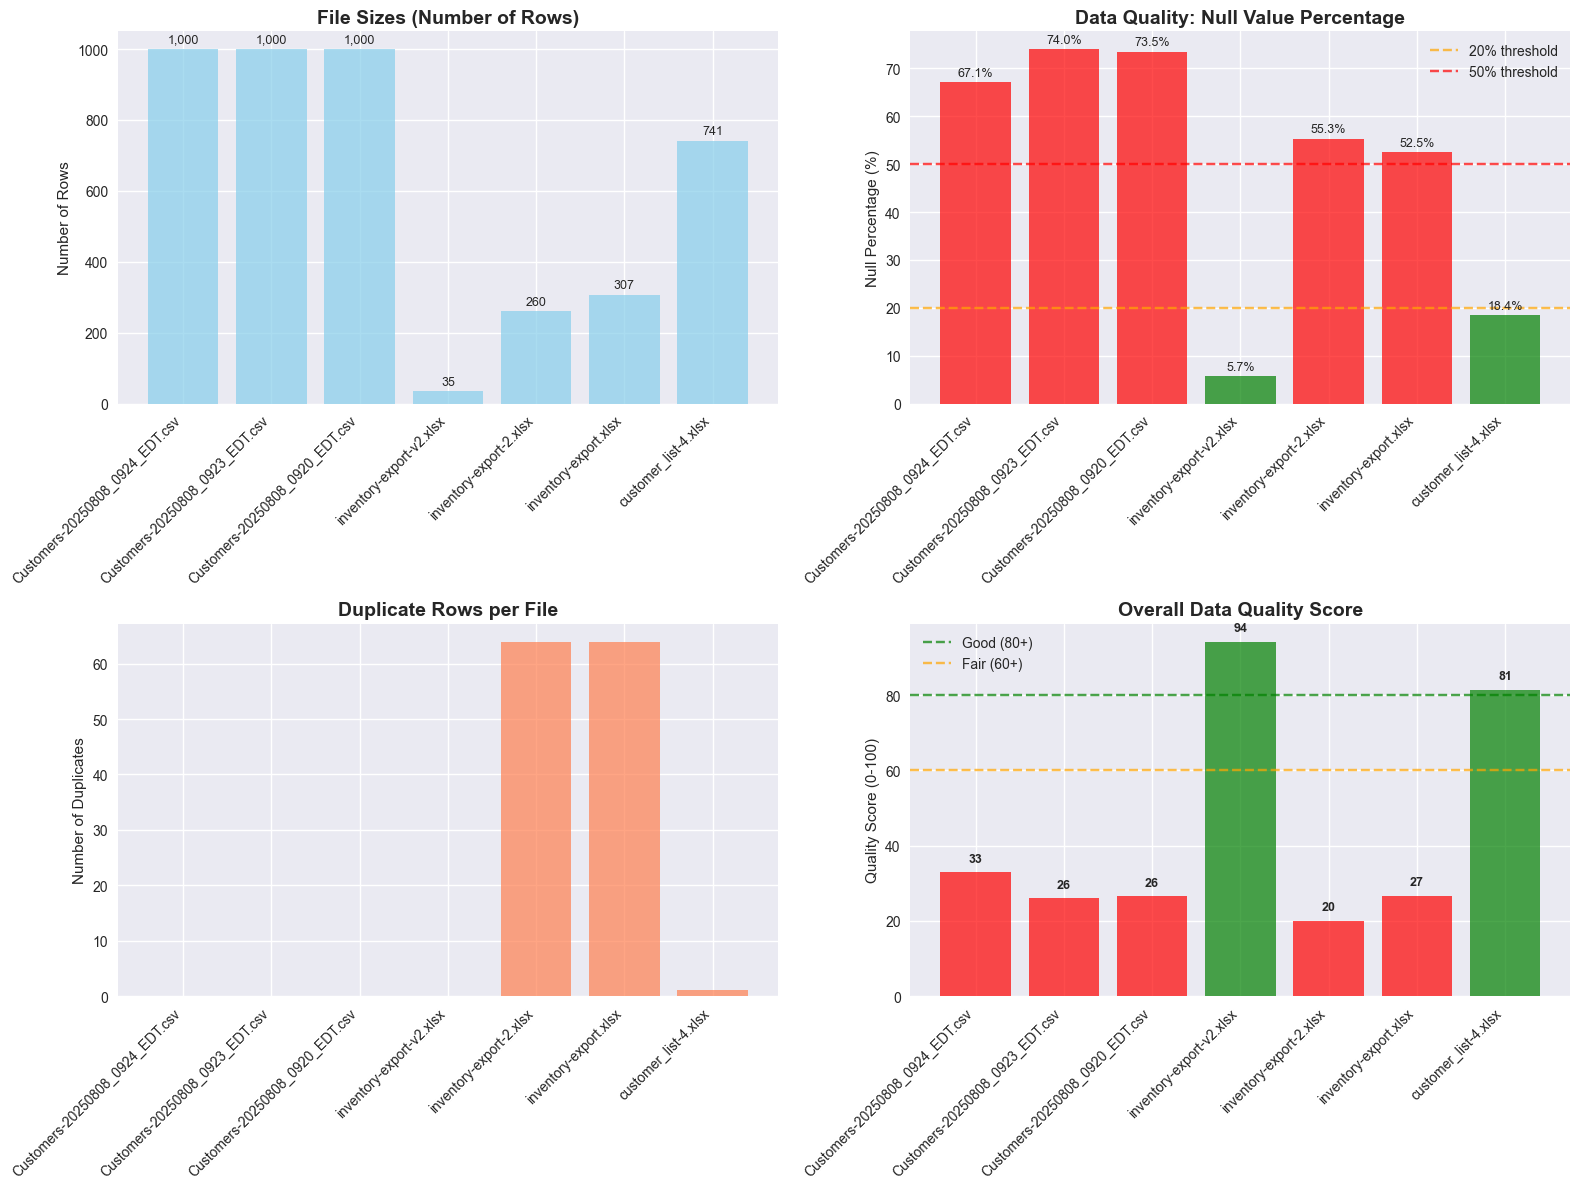

Total files analyzed: 7
Total rows across all files: 4,343
Average null percentage: 49.5%
Files with high null rate (>20%): 5
Files with duplicates: 3
Average quality score: 44.0/100


In [9]:
if not quality_df.empty:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    ax1.bar(range(len(quality_df)), quality_df['total_rows'], color='skyblue', alpha=0.7)
    ax1.set_title('File Sizes (Number of Rows)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Rows')
    ax1.set_xticks(range(len(quality_df)))
    ax1.set_xticklabels(quality_df['filename'], rotation=45, ha='right')
    
    for i, v in enumerate(quality_df['total_rows']):
        ax1.text(i, v + max(quality_df['total_rows']) * 0.01, f'{v:,}', 
                ha='center', va='bottom', fontsize=9)
    
    colors = ['red' if x > 50 else 'orange' if x > 20 else 'green' for x in quality_df['null_percentage']]
    ax2.bar(range(len(quality_df)), quality_df['null_percentage'], color=colors, alpha=0.7)
    ax2.set_title('Data Quality: Null Value Percentage', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Null Percentage (%)')
    ax2.set_xticks(range(len(quality_df)))
    ax2.set_xticklabels(quality_df['filename'], rotation=45, ha='right')
    ax2.axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='20% threshold')
    ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
    ax2.legend()
    
    for i, v in enumerate(quality_df['null_percentage']):
        ax2.text(i, v + max(quality_df['null_percentage']) * 0.01, f'{v:.1f}%', 
                ha='center', va='bottom', fontsize=9)
    
    ax3.bar(range(len(quality_df)), quality_df['duplicate_rows'], color='coral', alpha=0.7)
    ax3.set_title('Duplicate Rows per File', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Number of Duplicates')
    ax3.set_xticks(range(len(quality_df)))
    ax3.set_xticklabels(quality_df['filename'], rotation=45, ha='right')
    
    quality_df['duplicate_rate'] = (quality_df['duplicate_rows'] / quality_df['total_rows'] * 100).fillna(0)
    quality_df['quality_score'] = np.maximum(0, 100 - quality_df['null_percentage'] - quality_df['duplicate_rate'])
    
    colors = ['green' if x > 80 else 'orange' if x > 60 else 'red' for x in quality_df['quality_score']]
    ax4.bar(range(len(quality_df)), quality_df['quality_score'], color=colors, alpha=0.7)
    ax4.set_title('Overall Data Quality Score', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Quality Score (0-100)')
    ax4.set_xticks(range(len(quality_df)))
    ax4.set_xticklabels(quality_df['filename'], rotation=45, ha='right')
    ax4.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Good (80+)')
    ax4.axhline(y=60, color='orange', linestyle='--', alpha=0.7, label='Fair (60+)')
    ax4.legend()
    
    for i, v in enumerate(quality_df['quality_score']):
        ax4.text(i, v + 2, f'{v:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total files analyzed: {len(quality_df)}")
    print(f"Total rows across all files: {quality_df['total_rows'].sum():,}")
    print(f"Average null percentage: {quality_df['null_percentage'].mean():.1f}%")
    print(f"Files with high null rate (>20%): {(quality_df['null_percentage'] > 20).sum()}")
    print(f"Files with duplicates: {(quality_df['duplicate_rows'] > 0).sum()}")
    print(f"Average quality score: {quality_df['quality_score'].mean():.1f}/100")
else:
    print("No valid data files found for visualization")

In [10]:
def clean_customer_data(df):
    original_count = len(df)
    key_fields = ['First Name', 'Last Name', 'Email Address', 'Phone Number']
    existing_key_fields = [field for field in key_fields if field in df.columns]
    
    if existing_key_fields:
        mask = df[existing_key_fields].notna().any(axis=1)
        df = df[mask]
    
    if 'Phone Number' in df.columns:
        def clean_phone(phone):
            if pd.isna(phone):
                return phone
            phone_str = str(phone).strip()
            phone_digits = re.sub(r'[^\d]', '', phone_str)
            if len(phone_digits) < 10 or len(phone_digits) > 11:
                return None
            return phone_str
        
        df['Phone Number'] = df['Phone Number'].apply(clean_phone)
    
    if 'Email Address' in df.columns:
        def clean_email(email):
            if pd.isna(email):
                return email
            email_str = str(email).strip().lower()
            if '@' not in email_str or '.' not in email_str:
                return None
            if len(email_str) < 5 or email_str.count('@') != 1:
                return None
            return email_str
        
        df['Email Address'] = df['Email Address'].apply(clean_email)
    
    for name_field in ['First Name', 'Last Name']:
        if name_field in df.columns:
            def clean_name(name):
                if pd.isna(name):
                    return name
                name_str = str(name).strip()
                if len(name_str) < 2 or name_str.isdigit():
                    return None
                return name_str.title()
            
            df[name_field] = df[name_field].apply(clean_name)
    
    if 'Customer Since' in df.columns:
        df['Customer Since'] = pd.to_datetime(df['Customer Since'], errors='coerce')
        future_mask = df['Customer Since'] > datetime.now()
        df.loc[future_mask, 'Customer Since'] = None
    
    if 'Email Address' in df.columns:
        df = df.drop_duplicates(subset=['Email Address'], keep='first')
    elif 'Phone Number' in df.columns:
        df = df.drop_duplicates(subset=['Phone Number'], keep='first')
    
    cleaned_count = len(df)
    
    return df, {
        'original_rows': original_count,
        'cleaned_rows': cleaned_count,
        'rows_removed': original_count - cleaned_count,
        'removal_rate': (original_count - cleaned_count) / original_count * 100 if original_count > 0 else 0
    }

In [11]:
def clean_sales_data(df):
    original_count = len(df)
    df = df.dropna(how='all')
    
    if len(df.columns) > 1:
        def is_item_row(row):
            try:
                second_col = str(row.iloc[1]).strip()
                return '$' in second_col or second_col.replace('.', '').replace(',', '').isdigit()
            except:
                return False
        
        header_rows = df.head(15)
        item_mask = df.apply(is_item_row, axis=1)
        item_rows = df[item_mask]
        
        if len(item_rows) > 0:
            df = pd.concat([header_rows, item_rows], ignore_index=True)
            df = df.drop_duplicates(keep='first')
    
    cleaned_count = len(df)
    
    return df, {
        'original_rows': original_count,
        'cleaned_rows': cleaned_count,
        'rows_removed': original_count - cleaned_count,
        'removal_rate': (original_count - cleaned_count) / original_count * 100 if original_count > 0 else 0
    }

In [12]:
def clean_business_data(df):
    original_count = len(df)
    
    if 'Legal Business Name' in df.columns:
        df = df[df['Legal Business Name'].notna() & (df['Legal Business Name'] != '')]
    
    volume_columns = ['MTD Volume', 'Last Month Volume', 'Total Volume']
    for col in volume_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
    if 'Registration Date' in df.columns:
        df['Registration Date'] = pd.to_datetime(df['Registration Date'], errors='coerce')
        
    if 'Legal Business Name' in df.columns:
        df = df.drop_duplicates(subset=['Legal Business Name'], keep='first')
    
    cleaned_count = len(df)
    
    return df, {
        'original_rows': original_count,
        'cleaned_rows': cleaned_count,
        'rows_removed': original_count - cleaned_count,
        'removal_rate': (original_count - cleaned_count) / original_count * 100 if original_count > 0 else 0
    }

In [13]:
def clean_inventory_data(df):
    original_count = len(df)
    name_columns = ['Name', 'Item Name', 'Product Name']
    name_col = None
    for col in name_columns:
        if col in df.columns:
            name_col = col
            break
        
    if name_col:
        df = df[df[name_col].notna() & (df[name_col] != '')]
    
    price_columns = ['Price', 'Cost', 'Sale Price']
    for col in price_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df = df[(df[col] >= 0) | df[col].isna()]
    
    if name_col:
        df = df.drop_duplicates(subset=[name_col], keep='first')
    
    cleaned_count = len(df)
    
    return df, {
        'original_rows': original_count,
        'cleaned_rows': cleaned_count,
        'rows_removed': original_count - cleaned_count,
        'removal_rate': (original_count - cleaned_count) / original_count * 100 if original_count > 0 else 0
    }

In [14]:
def determine_file_type(filename):
    filename_lower = filename.lower()
    
    if 'customer' in filename_lower:
        return 'customer'
    elif 'revenue' in filename_lower or 'sales' in filename_lower:
        return 'sales'
    elif 'inventory' in filename_lower:
        return 'inventory'
    elif 'business' in filename_lower or 'customer_list' in filename_lower:
        return 'business'
    else:
        return 'unknown'

In [ ]:
cleaning_results = {}
total_original_rows = 0
total_cleaned_rows = 0

for file_path in all_files:
    filename = os.path.basename(file_path)
    print(f"\nProcessing: {filename}")
    
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path, encoding='utf-8-sig')
        else:
            df = pd.read_excel(file_path)
        
        file_type = determine_file_type(filename)
        
        if file_type == 'customer':
            cleaned_df, stats = clean_customer_data(df.copy())
        elif file_type == 'sales':
            cleaned_df, stats = clean_sales_data(df.copy())
        elif file_type == 'business':
            cleaned_df, stats = clean_business_data(df.copy())
        elif file_type == 'inventory':
            cleaned_df, stats = clean_inventory_data(df.copy())
        else:
            original_count = len(df)
            cleaned_df = df.dropna(how='all')
            cleaned_count = len(cleaned_df)
            stats = {
                'original_rows': original_count,
                'cleaned_rows': cleaned_count,
                'rows_removed': original_count - cleaned_count,
                'removal_rate': (original_count - cleaned_count) / original_count * 100 if original_count > 0 else 0
            }
        output_file = os.path.join(OUTPUT_PATH, filename)
        if file_path.endswith('.csv'):
            cleaned_df.to_csv(output_file, index=False)
        else:
            cleaned_df.to_excel(output_file, index=False)
        cleaning_results[filename] = {
            'file_type': file_type,
            **stats
        }
        
        total_original_rows += stats['original_rows']
        total_cleaned_rows += stats['cleaned_rows']
        
        print(f" {stats['original_rows']:,} → {stats['cleaned_rows']:,} rows ({stats['removal_rate']:.1f}% removed)")
        
    except Exception as e:
        print(f" Error processing {filename}: {str(e)}")
        cleaning_results[filename] = {
            'file_type': 'error',
            'error': str(e)
        }

print(f"Total rows: {total_original_rows:,} → {total_cleaned_rows:,}")
if total_original_rows > 0:
    overall_reduction = (total_original_rows - total_cleaned_rows) / total_original_rows * 100
    print(f"Overall data reduction: {overall_reduction:.2f}%")